In [2]:
import os
import time
import numpy as np
import librosa
import pickle
import math
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.signal import argrelextrema
from copy import deepcopy
from midiutil import MIDIFile

# Install and setup external dependencies
def install_dependencies():
    os.system('nvcc --version')
    os.system('git clone https://github.com/bwohlberg/sporco-cuda.git')
    os.environ["CUDAHOME"] = "/usr/local/cuda-11.8"
    os.system('cd sporco-cuda && python setup.py build && python setup.py test && python setup.py install')
    os.system('pip install sporco')
    os.system('pip install midiutil')
    os.system('pip install librosa --upgrade')
    os.system('pip install soundfile')

# Import sporco related modules after installation
def import_sporco_modules():
    from sporco import cuda
    from sporco.admm import cbpdn
    import sporco.metric as sm

# For Google Colab only
def import_google_colab():
    from google.colab import files

# Main function
def main():
    install_dependencies()
    import_sporco_modules()
    import_google_colab()

if __name__ == "__main__":
    main()


In [11]:
# Constants
SR = 11025  # Sample rate
WINDOW_SIZE = 0.050
MUSIC_PATH = '/content/drive/MyDrive/MUS/MAPS_MUS-mz_311_1_ENSTDkCl_SuperEdited.wav'
GROUND_TRUTH_PATH = '/content/drive/MyDrive/MUS/MAPS_MUS-mz_311_1_ENSTDkCl.txt'
DURATION = 30.0
ABBREV = 'esp2'
DICTIONARY_DIRECTORY = '/content/drive/MyDrive/NO/'
DICTIONARY_NAME = 'MAPS_NO_dict_ENSTDkCl'
LAMBDA = 0.005
DIM_N = 1

def load_and_normalize(note_id):
    file_name = f'MAPS_ISOL_NO_F_S0_M{note_id}_ENSTDkCl.wav'
    try:
        sample = librosa.load(os.path.join(DICTIONARY_DIRECTORY, file_name), sr=SR, offset=0.7, duration=1.0)[0]
    except:
        file_name = f'MAPS_ISOL_NO_F_S1_M{note_id}_ENSTDkCl.wav'
        sample = librosa.load(os.path.join(DICTIONARY_DIRECTORY, file_name), sr=SR, offset=0.7, duration=1.0)[0]
    return sample / np.amax(sample)

# Load and normalize dictionary elements
DICTIONARY_ELEMENTS = [load_and_normalize(note_id) for note_id in range(21, 109)]

# Save and reload the dictionary
D = np.array(DICTIONARY_ELEMENTS).T
with open(f'{DICTIONARY_NAME}.pkl', 'wb') as file:
    pickle.dump(D, file)

with open(f'{DICTIONARY_NAME}.pkl', 'rb') as file:
    D = pickle.load(file)

# Load the music file
song, _ = librosa.load(MUSIC_PATH, sr=SR, duration=DURATION)

# Initialize parameters and options for the ConvBPDN algorithm
options = {
    'Verbose': True,
    'MaxMainIter': 500,
    'HighMemSolve': True,
    'LinSolveCheck': False,
    'RelStopTol': 1e-3,
    'AuxVarObj': False
}

# Execute and time the CBPDN algorithm
solver = cbpdn.ConvBPDN(D, song, LAMBDA, options, dimN=DIM_N)
start_time = time.time()
X = solver.solve()
print(f"Solving took: {time.time() - start_time} seconds")

# Save results to a file
X = X[:, 0, 0, :]
results_file_name = f'maps_results_{ABBREV}.pkl'
with open(results_file_name, 'wb') as file:
    pickle.dump(X, file)

# Download the results file
files.download(results_file_name)

# Load the ground truth
with open(GROUND_TRUTH_PATH, 'rb') as file:
    lines = file.readlines()[1:]
GROUND_TRUTH = {}
NUM_TIMESETS = 0

<ipython-input-11-50897ba2d053>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  sample = librosa.load(os.path.join(DICTIONARY_DIRECTORY, file_name), sr=SR, offset=0.7, duration=1.0)[0]


Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  2.77e+00  2.69e+00  1.60e+01  1.00e+00  0.00e+00  1.25e+00
   1  2.74e+00  2.66e+00  1.60e+01  1.00e+00  0.00e+00  1.25e+00
   2  1.02e-01  1.91e-02  1.65e+01  3.97e-01  4.61e+00  1.25e+03
   3  1.29e-01  2.56e-03  2.53e+01  4.60e-01  9.65e-01  3.63e+02
   4  1.28e-01  2.52e-03  2.50e+01  4.99e-01  3.83e-01  2.47e+02
   5  1.04e-01  2.16e-03  2.03e+01  3.26e-01  3.34e-01  2.79e+02
   6  8.96e-02  1.82e-03  1.76e+01  2.55e-01  2.89e-01  2.79e+02
   7  7.78e-02  1.83e-03  1.52e+01  2.07e-01  2.23e-01  2.79e+02
   8  6.97e-02  1.86e-03  1.36e+01  1.59e-01  2.08e-01  2.79e+02
   9  6.79e-02  1.76e-03  1.32e+01  1.42e-01  1.79e-01  2.41e+02
  10  6.46e-02  1.69e-03  1.26e+01  1.28e-01  1.61e-01  2.12e+02
  11  6.14e-02  1.67e-03  1.19e+01  1.15e-01  1.39e-01  1.87e+02
  12  5.83e-02  1.70e-03  1.13e+01  1.00e-01  1.24e-01  1.68e+02
  13  5.61e-02  1.66e-03 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Process ground truth data
for row in lines:
    row = row.decode().strip('\r\n').split('\t')
    start_time, end_time, note_num = float(row[0]), float(row[1]), row[2]
    
    if start_time > DURATION:
        break

    if note_num in GROUND_TRUTH:
        GROUND_TRUTH[note_num].append([start_time, end_time])
    else:
        GROUND_TRUTH[note_num] = [[start_time, end_time]]

    NUM_TIMESETS += 1

print(NUM_TIMESETS)


336


In [13]:
# Load activation vectors from disk
results_name = f'maps_results_{ABBREV}.pkl'
with open(results_name, 'rb') as file:
    y1 = pickle.load(file)

# Deep copy and slice the activation vectors
y = deepcopy(y1)[0:330750, :]
print(y.shape)


(33355, 88)


In [15]:
# Constants
IQR_MULTIPLIER = 1.5  # Adjust as necessary

# Extract local maxima values from y
local_maxima_values = []
for row in y:
    maxima_indices = argrelextrema(row, np.greater)[0]
    local_maxima_values.extend(row[maxima_indices])

# Calculate binarization threshold using interquartile range (IQR) and multiplier
q1, q3 = np.percentile(local_maxima_values, [25, 75])
iqr = q3 - q1
binarization_threshold = q3 + IQR_MULTIPLIER * iqr

# Apply binarization threshold to y
y[y < binarization_threshold] = 0

# Print the binarization threshold
print(binarization_threshold)


0.0007420853653457016


In [36]:
# Initialize the counter for time sets
num_timesets = 0

# Iterate through the lines and process the ground truth data
for row in lines:
    # Decode and split the row elements
    row_elements = row.decode().strip('\r\n').split('\t')
    start_time, end_time, note_num = float(row_elements[0]), float(row_elements[1]), row_elements[2]

    # Check if the start time exceeds the duration
    if start_time > DURATION:
        break

    # Update the GROUND_TRUTH dictionary with the note information
    GROUND_TRUTH.setdefault(note_num, []).append([start_time, end_time])
    
    # Increment the time sets counter
    num_timesets += 1

# Update the total number of time sets processed
NUM_TIMESETS += num_timesets
print(NUM_TIMESETS)


3360


In [37]:
# Load activation vectors
with open(results_name, 'rb') as file:
    Y = pickle.load(file)

# Deepcopy for safety in case of multiple modifications
Y_original = deepcopy(Y)

# Truncate or pad to the desired duration
max_duration = 330750
Y = Y_original[:max_duration, :]

# Find local maxima ignoring negative peaks
lmaxes = []
for row in Y:
    maxima_indices = argrelextrema(row, np.greater)[0]
    lmaxes.extend(row[maxima_indices])
lmaxes = np.array(lmaxes)

# Calculate binarization threshold based on IQR
p75, p25 = np.percentile(lmaxes, [75, 25])
threshold = p75 + 8 * (p75 - p25)

# Binarize
Y[Y < threshold] = 0

# Print shape and binarization threshold
print(Y.shape)  # Should be (330750, 88)
print(threshold)  # Binarization threshold


(33355, 88)
0.0025410599482711405


In [29]:
# Initialization for parsing the 50ms windows
window_size = 0.05
num_windows = int(DURATION / window_size)
frame_length = int(SR * window_size)

# 2D array to represent onsets
onsets = np.zeros((88, num_windows))

# Variables for storing the highest and lowest notes (useful for potential plotting later)
highest_note = 0
lowest_note = 88  # MIDI note range is from 21 to 108

# Counters
total_notes = 0
correct_notes = 0
removed_notes = 0

# Deepcopy of the ground truth to avoid modifying the original
ground_truth_copy = deepcopy(GROUND_TRUTH)

for window_num in range(num_windows):
    # Extract current window frame from the signal
    start = window_num * frame_length
    end = start + frame_length
    current_frame = Y[start:end, :]

    summed_frame = np.sum(current_frame, axis=0)
    local_maxima = argrelextrema(summed_frame, np.greater)[0]

    if local_maxima.size:
        highest_note = max(highest_note, np.amax(local_maxima))
        lowest_note = min(lowest_note, np.amin(local_maxima))

        onsets[local_maxima, window_num] = 1

        current_time = window_size * window_num

        for note in local_maxima:
            midi_note = note + 21
            total_notes += 1

            if str(midi_note) in GROUND_TRUTH:
                time_ranges = GROUND_TRUTH[str(midi_note)]
                for onset_time, offset_time in time_ranges:
                    onset_time, offset_time = float(onset_time), float(offset_time)
                    if current_time >= onset_time - window_size and current_time <= offset_time + window_size:
                        correct_notes += 1
                        break

            if str(midi_note) in ground_truth_copy:
                note_time_ranges = deepcopy(ground_truth_copy[str(midi_note)])
                for idx, (onset_time, offset_time) in enumerate(note_time_ranges):
                    onset_time, offset_time = float(onset_time), float(offset_time)
                    if current_time >= onset_time - window_size and current_time <= offset_time + window_size:
                        note_time_ranges.pop(idx)
                        ground_truth_copy[str(midi_note)] = note_time_ranges
                        removed_notes += 1
                        break

# Calculate metrics
precision_val = float(correct_notes) / total_notes if total_notes else 0
recall_val = float(removed_notes) / NUM_TIMESETS if NUM_TIMESETS else 0
f1_score = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) else 0

print(f"Correct percentage is: {precision_val:.2f}")
print(f"Detected percentage is: {recall_val:.2f}")
print(f"F1 score is: {f1_score:.2f}")


Correct percentage is: 0.73
Detected percentage is: 0.01
F1 score is: 0.02


In [33]:
import matplotlib.pyplot as plt

# Plot ground truth
last_time = onsets.shape[1] * window_size
gt_plot = np.zeros(onsets.shape)

# Populate the ground truth matrix
for note_str, time_ranges in GROUND_TRUTH.items():
    note_index = int(note_str) - 21  # MIDI notes offset
    for onset, offset in time_ranges:
        onset_time = float(onset)
        if onset_time < last_time:
            time_index = int(onset_time // window_size)
            gt_plot[note_index, time_index] = 1

# Remove temporal information by comparing with the next frame
for i in range(onsets.shape[1] - 1):
    changes = onsets[:, i+1] - onsets[:, i]
    onsets[changes < 1, i+1] = 0

# Transform data for scatterplot
x1, y1, x2, y2 = [], [], [], []
for i in range(onsets.shape[1]):
    for j, (note_detected, note_ground_truth) in enumerate(zip(onsets[:, i], gt_plot[:, i])):
        if note_detected:
            x1.append(i)
            y1.append(j)
        if note_ground_truth:
            x2.append(i)
            y2.append(j)

# Create scatterplot
plt.figure(figsize=(10, 5))
plt.scatter(x1, y1, c='blue', marker='o', label='Detected Notes')
plt.scatter(x2, y2, c='red', marker='x', label='Ground Truth')
plt.xlabel('Time Windows')
plt.ylabel('MIDI Note')
plt.title('Comparison of Detected Notes and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of detected notes: {len(x1)}, Number in ground truth: {len(x2)}")
print(f"Shape of ground truth: {gt_plot.shape}")
print(f"Shape of detected notes: {onsets.shape}")


Number of detected notes: 41, Number in ground truth: 336
Shape of ground truth: (88, 600)
Shape of detected notes: (88, 600)


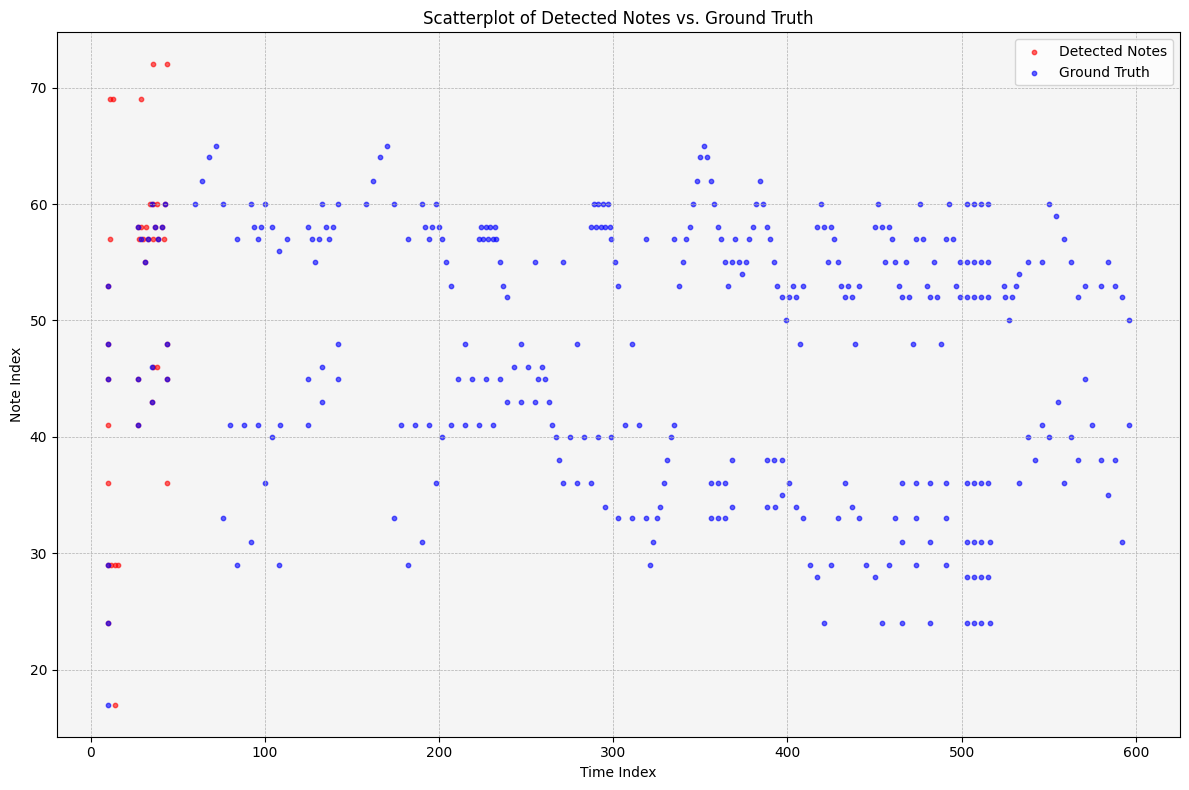

In [34]:
import matplotlib.pyplot as plt

# Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot for detected notes (in red)
ax.scatter(x1, y1, color='red', label='Detected Notes', s=10, alpha=0.6)

# Plot for ground truth (in blue)
ax.scatter(x2, y2, color='blue', label='Ground Truth', s=10, alpha=0.6)

# Formatting
ax.set_title("Scatterplot of Detected Notes vs. Ground Truth")
ax.set_xlabel("Time Index")
ax.set_ylabel("Note Index")
ax.legend(loc="upper right")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_facecolor('whitesmoke')

# Display
plt.tight_layout()
plt.show()


In [35]:
# Constants
TRACK = 0
CHANNEL = 0
TIME = 0  # In beats.
DURATION = 0.2  # Duration of each note in the MIDI file.
TEMP_RATE = 60  # We choose 60BPM because that allows easy divisions by seconds.
VOLUME = 100  # 0-127, as per the MIDI standard.

# Create the ground truth MIDI track.
gt_track = MIDIFile(1, adjust_origin=False)  # One track, format 0 (single track)
gt_track.addTempo(TRACK, TIME, TEMP_RATE)

# Populate the ground truth MIDI track with notes.
for i in range(len(x2)):
    # Time windows progress by 50ms.
    t = x2[i] * 0.050
    # MIDI pitch offset is 21, i.e., the lowest note on a piano is MIDI note number 21.
    pitch = y2[i] + 21
    gt_track.addNote(TRACK, CHANNEL, pitch, t, DURATION, VOLUME)

# Write the ground truth MIDI track to disk.
gt_file_name = f"gt_midi_{ABBREV}.mid"
with open(gt_file_name, "wb") as output_file:
    gt_track.writeFile(output_file)

# Create and populate the transcribed MIDI track.
transcribed_track = MIDIFile(1, adjust_origin=False)
transcribed_track.addTempo(TRACK, TIME, TEMP_RATE)

for i in range(len(x1)):
    t = x1[i] * 0.050
    pitch = y1[i] + 21
    transcribed_track.addNote(TRACK, CHANNEL, pitch, t, DURATION, VOLUME)

# Write the transcribed MIDI track to disk.
transcribed_file_name = f"transcribed_midi_{ABBREV}.mid"
with open(transcribed_file_name, "wb") as output_file:
    transcribed_track.writeFile(output_file)